In [190]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
import pandas as pd

#### **Utils**

In [152]:
def scatter_plot(X, title="", marker="."):
    if X.shape[1] == 2:
        # 2D Scatter plot
        plt.scatter(X[:, 0], X[:, 1], label="Sample", marker=marker)
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.axis('equal')  # Assurer que les axes x et y ont la même échelle
        plt.legend()
        plt.title(title)
    elif X.shape[1] == 3:
        # 3D Scatter plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], label="Sample", marker=marker)
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('X3')
        plt.legend()
        plt.title(title)
    else:
        print("This function only supports 2D and 3D data.")

    plt.show()

In [199]:
max_iter = 2000

## Hypersphere Direction Algorithm

Given an open bounded $d$-dimensional set $S$, we aim to generate efficiently points uniformly distributed over $S$.


*   $\pi$ is the uniform distribution in $S$.
*   $\nu$ is the uniform distribution on $\partial D$.

We consider $S = S_{a,b}(r)= \left\{ (x, y) \in \mathbb{R}^2 : (x - a)^2 + (y - b)^2 \leq r^2 \right\}$






**Case 1**: Let $S = \mathcal{B}_d(0,1)$ the unit ball on $\mathbb{R}^d $ (meaning $a = b = 0, r = 1$), and $\theta_k \in \partial D$.
We choose $\lambda \in \Lambda_k = \{\lambda \in \mathbb{R}, x_k + \lambda \theta_k \in S\}$ from the distribution of density
 \begin{equation*}
    f_k(\lambda) = \frac{f(x_k + \lambda \theta_k)}{\int_{\Lambda_k}f(x_k + r \theta_k)dr}.
\end{equation*}
We have that $f_k$ is the density of the uniform distribution on $\Lambda_k$. Indeed, since $f(x) = \frac{1}{\pi} 1_S(x)$,
\begin{align*}
  f(x_k + \lambda \theta_k) & = \frac{1}{\pi} 1_S(x_k + \lambda \theta_k) \\
  & = \frac{1}{\pi} 1_{\Lambda_k}(\lambda).
\end{align*}
Then,
\begin{equation*}
f_k(\lambda) = \frac{1}{\phi(\Lambda_k)} 1_{\Lambda_k}(\lambda)
\end{equation*}
where $\phi$ denotes the Lebesgue measure on $S$. Finally, since $S = \mathcal{B}_d(0,1)$,
\begin{equation*}
\Lambda_k = [-x_k^T\theta_k - \Delta_k,-x_k^T\theta_k + \Delta_k]
\end{equation*}
where $\Delta_k = \sqrt{-x_k^Tx_k + (x_k^T\theta_k)^2 + 1}$

In [154]:
def sample_lambda_uniform_centered(n_samples,x,theta):
    # Via transformation technique
    z = x@theta
    Delta = np.sqrt(-x@x + z**2 + 1)
    X = np.random.uniform(0, 1, n_samples)
    X = 2*Delta*X-Delta-z
    return X

**Case 2** : Let $S = \mathcal{B}_d(x_c,1)$ where $x_c \in \mathbb{R}^d$. The reasoning remains the same, and $\Lambda_k$ becomes
\begin{equation*}
\Lambda_k = \left[-\frac{(x_k-x_c)^T\theta_k}{\theta_k^T \theta_k} \mp \Delta_k \right]
\end{equation*}
where $\Delta_k = \frac{\sqrt{\left((x_k-x_c)^T\theta_k\right)^2 - (\theta_k^T\theta_k)\left((x_k-x_c)^T(x_k-x_c) - 1\right)}}{\theta_k^T\theta_k}$


In [155]:
def sample_lambda_uniform(n_samples,x_center,x,theta):
    # Via transformation technique
    z = (x-x_center)@theta/(theta@theta)
    Delta = np.sqrt(((x-x_center)@theta)**2 - (theta@theta)*((x-x_center)@(x-x_center) - 1))/(theta@theta)
    X = np.random.uniform(0, 1, n_samples)
    X = 2*Delta*X-Delta-z
    return X

**Case 3**: Union of balls. We merge the intervals. Indeed,
\begin{equation*}
x + \lambda \theta \in \mathcal{B}_1 \cup \mathcal{B_2} \Longleftrightarrow \lambda \in \Lambda^1 \cup \Lambda^2
\end{equation*}
where $\Lambda^i = \{\lambda \in \mathbb{R}, x + \lambda \theta \in \mathcal{B_i} \}$

In [156]:
def sample_from_union_intervals(n_samples,interval1, interval2):
    '''
    Echantillonne uniformement sur une union d'intervalles (disjoints ou non)
    '''
    # Vérifier si un intervalle est inclus dans l'autre
    if interval1[0] <= interval2[0] and interval1[1] >= interval2[1]:
        # interval2 est inclus dans interval1
        interval_to_use = interval1
    elif interval2[0] <= interval1[0] and interval2[1] >= interval1[1]:
        # interval1 est inclus dans interval2
        interval_to_use = interval2
    else:
        # Les intervalles ne sont pas inclus l'un dans l'autre
        length1 = interval1[1] - interval1[0]
        length2 = interval2[1] - interval2[0]
        total_length = length1 + length2
        samples = np.random.uniform(0, 1, n_samples)
        scaled_samples = samples * total_length
        return np.where(
            scaled_samples <= length1,
            scaled_samples + interval1[0],
            scaled_samples - length1 + interval2[0]
        )

    # Générer des échantillons pour l'intervalle choisi
    X = np.random.uniform(0, 1, n_samples)
    return interval_to_use[0] + (interval_to_use[1]-interval_to_use[0])*X



def sample_lambda_uniform_union(n_samples,x_center_1,x_center_2,x,theta):
    # On échantillonne sur l'union des intervalles Lambda
    q_1 = ((x-x_center_1)@theta)**2 - (theta@theta)*((x-x_center_1)@(x-x_center_1) - 1)
    q_2 = ((x-x_center_2)@theta)**2 - (theta@theta)*((x-x_center_2)@(x-x_center_2) - 1)
    lower_1,lower_2 = np.inf,np.inf
    if q_1 >= 0:
      z_1 = (x-x_center_1)@theta/(theta@theta)
      Delta_1 = np.sqrt(q_1)/(theta@theta)
      lower_1,upper_1 = -z_1 - Delta_1,-z_1 + Delta_1
    if q_2 >= 0:
      z_2 = (x-x_center_2)@theta/(theta@theta)
      Delta_2 = np.sqrt(q_2)/(theta@theta)
      lower_2,upper_2 = -z_2 - Delta_2,-z_2 + Delta_2
    if lower_1 == np.inf:
      lower_1 = lower_2
      upper_1 = upper_2
    if lower_2 == np.inf:
      lower_2 = lower_1
      upper_2 = upper_1

    return sample_from_union_intervals(n_samples,[lower_1,upper_1], [lower_2,upper_2])
'''
interval1 = [0, 10]
interval2 = [3, 4]
n_samples = 10000

samples = sample_from_union_intervals(n_samples, interval1, interval2)

# Affichage des résultats avec un histogramme
plt.hist(samples, bins=10, edgecolor='black')
plt.title('Histogramme des échantillons de la distribution uniforme sur l\'union de [0, 2] et [5, 7]')
plt.xlabel('Valeur de l\'échantillon')
plt.ylabel('Nombre d\'échantillons')
plt.show()
'''

"\ninterval1 = [0, 10]\ninterval2 = [3, 4]\nn_samples = 10000\n\nsamples = sample_from_union_intervals(n_samples, interval1, interval2)\n\n# Affichage des résultats avec un histogramme\nplt.hist(samples, bins=10, edgecolor='black')\nplt.title('Histogramme des échantillons de la distribution uniforme sur l'union de [0, 2] et [5, 7]')\nplt.xlabel('Valeur de l'échantillon')\nplt.ylabel('Nombre d'échantillons')\nplt.show()\n"

The simplest way to sample from such a distribution $\nu$ is to generate $n$ independant normally distributed r.v deviates $N = (N_1,\dots,N_n)$ and to calculate $N/\|N\|$.

In [157]:
def sample_theta_uniform_sphere(n_samples, d=2):
    V = np.random.normal(0, 1, (n_samples, d))
    norms = np.linalg.norm(V, axis=1)
    V_norm = V / norms[:, np.newaxis]

    return V_norm

Main algorithms

In [158]:
def HDA_Centered_Ball(x0,d,max_iter=1000):
  '''
  Implements the Hypersphere Direction Algorithm for sampling pi = uniform on the disk for d = 2.
  '''
  x = x0
  x_list = [x]
  for k in tqdm(range(1,max_iter)):
    theta = sample_theta_uniform_sphere(1,d)[0]
    lambd = sample_lambda_uniform_centered(1,x,theta)[0]
    x = x + lambd*theta
    x_list.append(x)
  return np.array(x_list)

In [159]:
def HDA_Ball(x0,d,x_center,max_iter=1000):
  '''
  Implements the Hypersphere Direction Algorithm for sampling pi = uniform on the disk for d = 2.
  '''
  x = x0
  x_list = [x]
  for k in tqdm(range(1,max_iter)):
    theta = sample_theta_uniform_sphere(1,d)[0]
    lambd = sample_lambda_uniform(1,x_center,x,theta)[0]
    x = x + lambd*theta
    x_list.append(x)
  return np.array(x_list)

In [160]:
def HDA_Union_Balls(x0,d,x_center_1,x_center_2,max_iter=1000,verbose=1):
  '''
  Implements the Hypersphere Direction Algorithm for sampling pi = uniform on the disk for d = 2.
  '''
  x = x0
  x_list = [x]
  if verbose: rang = tqdm(range(1,max_iter))
  else: rang = range(1,max_iter)
  for k in rang:
    theta = sample_theta_uniform_sphere(1,d)[0]
    lambd = sample_lambda_uniform_union(1,x_center_1,x_center_2,x,theta)[0]
    x = x + lambd*theta
    x_list.append(x)
  return np.array(x_list)

**Case 1**: Centered Unit Ball

In [161]:
# We choose x0 in S
d = 3
x0 = np.zeros(d)
X = HDA_Centered_Ball(x0,d,max_iter)

100%|██████████| 1999/1999 [00:00<00:00, 27145.01it/s]


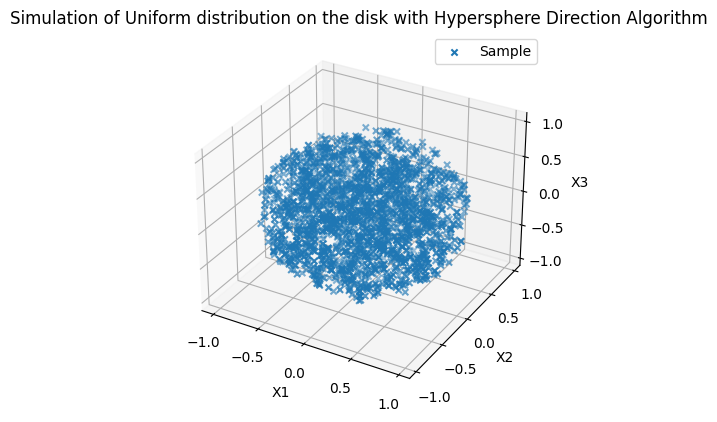

In [162]:
scatter_plot(X,title="Simulation of Uniform distribution on the disk with Hypersphere Direction Algorithm",marker='x')

We compare to the classical acceptation-reject algorithm for $d = 2$.

In [200]:
def sample_disk_reject(n_samples=1000):
    X = np.empty((n_samples, 2))
    count = 0
    for i in tqdm(range(n_samples)):
        while True:
            u1, u2 = 2 * np.random.rand(2) - 1
            if u1**2 + u2**2 <= 1:
                X[i] = [u1, u2]
                break
    return X

In [201]:
X = sample_disk_reject(max_iter)
print(X.shape)

100%|██████████| 2000/2000 [00:00<00:00, 67849.78it/s]

(2000, 2)


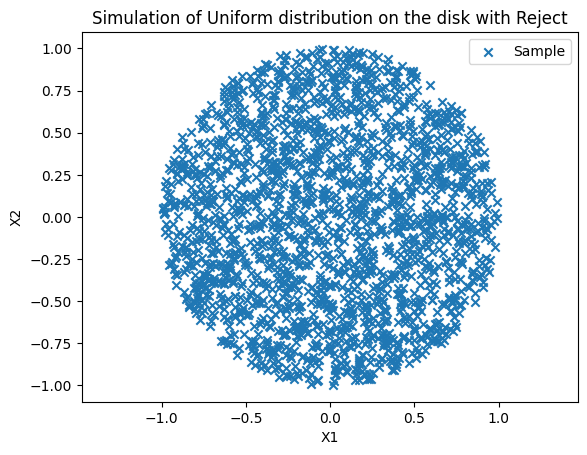

In [202]:
scatter_plot(X,title="Simulation of Uniform distribution on the disk with Reject",marker='x')

**Case 2**: Unit Ball

In [166]:
d = 2
x0 = np.array([-7,2])
X = HDA_Ball(x0,d,x0,max_iter)

100%|██████████| 1999/1999 [00:00<00:00, 18524.06it/s]


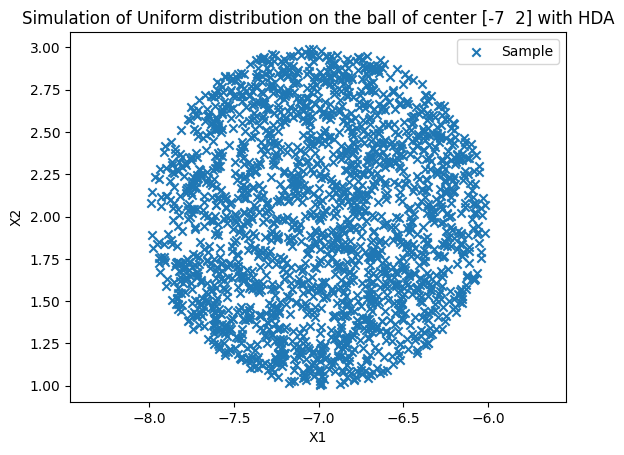

In [167]:
scatter_plot(X,title= f"Simulation of Uniform distribution on the ball of center {x0} with HDA",marker='x')

**Case 3**: Non Connexity / Union of Unit Balls

In [207]:
d = 2
x0 = np.array([0,0])
x_center_1 = np.array([0,0])
x_center_2 = np.array([5,0])
X = HDA_Union_Balls(x0,d,x_center_1,x_center_2,max_iter,1)

100%|██████████| 1999/1999 [00:00<00:00, 17421.51it/s]


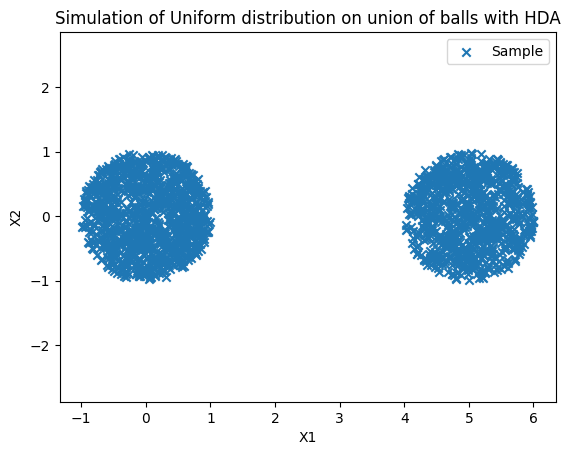

In [209]:
title = f"Simulation of Uniform distribution on union of balls with HDA"
scatter_plot(X,title=title,marker='x')

100%|██████████| 9999/9999 [00:00<00:00, 14917.18it/s]


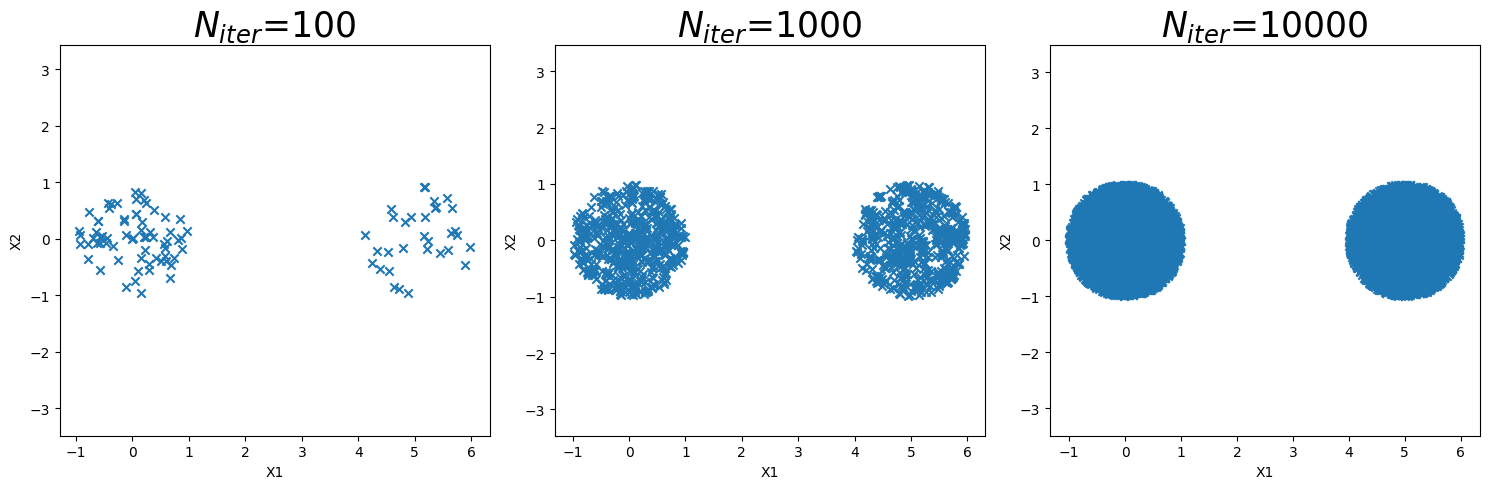

In [244]:
N_iter_list = [100, 1000, 10000]
x0 = np.array([0,0])
x_center_1 = np.array([0,0])
x_center_2 = np.array([5,0])
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, N_iter in enumerate(N_iter_list):
    ax = axes[i]  # Sélectionner le subplot approprié
    X = HDA_Union_Balls(x0, d, x_center_1, x_center_2, N_iter)  # Générer des échantillons

    # Plotter les échantillons directement dans le subplot
    ax.scatter(X[:, 0], X[:, 1], marker='x')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_title("$N_{iter}$" + f"={N_iter}", fontsize = 25)
    ax.axis('equal')  # Assurer que les axes x et y ont la même échelle

plt.tight_layout()
plt.show()

## Metropolis hasting - Symmetric random walk

The distribution $\pi$ we want to estimate is $\mathcal{U}(\mathcal{B}_1 \cup \mathcal{B}_2)$ where $\mathcal{B}_1$ and $\mathcal{B}_2$ are balls of radius $1$ in $\mathbb{R}^d$. We have
\begin{equation*}
\pi(x) \propto 1_{\{\mathcal{B}_1 \cup \mathcal{B}_2\}}(x)
\end{equation*}
As proposal, we consider the symmetric random walk.

In [171]:
def pi(x,x_center_1,x_center_2):
    a = (x-x_center_1)@(x-x_center_1) <= 1
    b = (x-x_center_2)@(x-x_center_2) <= 1
    return (a | b).astype(int)
def pi1(X, x_center_1, x_center_2):
    distances_to_center_1 = np.sum((X - x_center_1)**2, axis=1)
    distances_to_center_2 = np.sum((X - x_center_2)**2, axis=1)

    in_ball_1 = distances_to_center_1 <= 1
    in_ball_2 = distances_to_center_2 <= 1


    return (in_ball_1 | in_ball_2).astype(int)

In [172]:
def HM_SRW(x0,x_center_1,x_center_2,sigma_prop=10,max_iter=1000,verbose=1):

    #Initialization
    x = x0
    x_list = [x]
    acc=0

    if verbose: rang = tqdm(range(max_iter))
    else: rang = range(max_iter)

    for i in rang:
        # Proposal
        x_new = np.random.multivariate_normal(mean=x, cov=(sigma_prop**2)*np.eye(len(x0)))

        # Acceptance
        alpha = min(1,pi(x_new,x_center_1,x_center_2)/pi(x,x_center_1,x_center_2))
        u = np.random.rand()

        if u < alpha:
            x = x_new
            acc += 1

        x_list.append(x)

    if verbose > 1:
        print("\nTaux d'acceptation: ", acc/max_iter)

    return np.array(x_list)


In [239]:
x0 = np.array([0,0])
x_center_1 = np.array([0,0])
x_center_2 = np.array([5,0])
#print(np.sum((x0 - x_center_1)**2))
#print((x0-x_center_1)@(x0-x_center_1))
X = HM_SRW(x0,x_center_1,x_center_2,sigma_prop=1,max_iter=max_iter,verbose=2)

100%|██████████| 2000/2000 [00:00<00:00, 3355.97it/s]


Taux d'acceptation:  0.3325


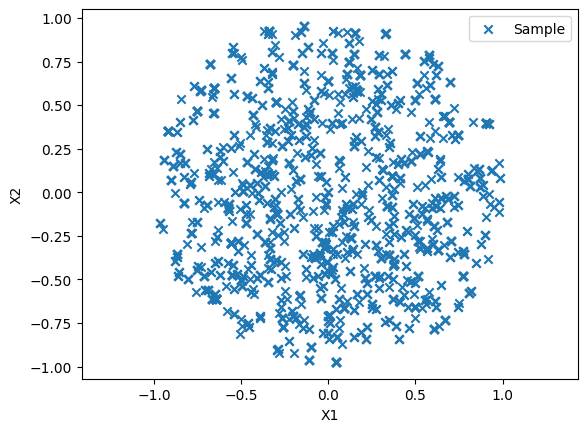

In [240]:
title= f"Simulation of Uniform distribution on union of balls with HM"
scatter_plot(X,marker='x')

100%|██████████| 100/100 [00:00<00:00, 3893.75it/s]



Taux d'acceptation:  0.0


100%|██████████| 1000/1000 [00:00<00:00, 3531.36it/s]



Taux d'acceptation:  0.013


100%|██████████| 10000/10000 [00:01<00:00, 6520.95it/s]



Taux d'acceptation:  0.0096


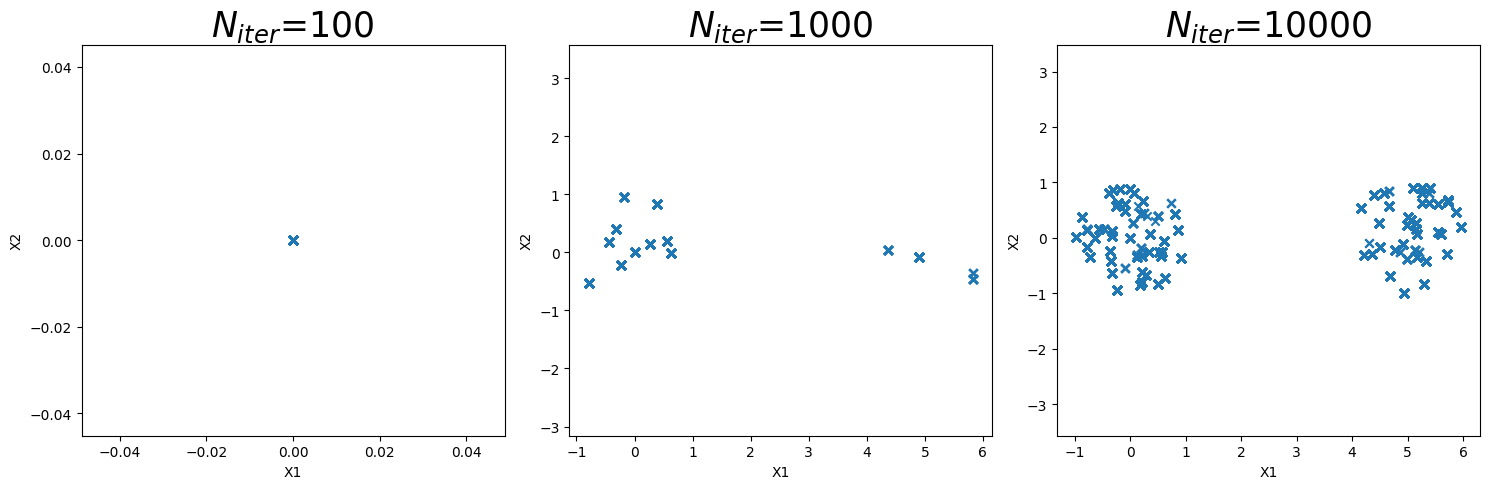

In [243]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
x0 = np.array([0,0])
x_center_1 = np.array([0,0])
x_center_2 = np.array([5,0])
N_iter_list = [100, 1000, 10000]
for i, N_iter in enumerate(N_iter_list):
    ax = axes[i]  # Sélectionner le subplot approprié
    X = HM_SRW(x0,x_center_1,x_center_2,sigma_prop=10,max_iter=N_iter,verbose=2)  # Générer des échantillons

    # Plotter les échantillons directement dans le subplot
    ax.scatter(X[:, 0], X[:, 1], marker='x')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_title("$N_{iter}$" + f"={N_iter}", fontsize = 25)
    ax.axis('equal')  # Assurer que les axes x et y ont la même échelle

plt.tight_layout()
plt.show()

Hasting Metropolis struggles to sample efficiently from the distribution $\pi$.

## Comparision between both in High Dimensional Case

In [186]:
d = 30
N = 100000
x0 = np.zeros(d)
x_center_1 = np.zeros(d)
x_center_2 = 5*np.ones(d)

start = time()
X_hda = HDA_Union_Balls(x0,d,x_center_1,x_center_2,N,1)
end_hda_time = time() - start

start = time()
X_hm = HM_SRW(x0,x_center_1,x_center_2,sigma_prop=10,max_iter=N,verbose=1)
end_hm_time = time() - start

n_hda,n_hm = len(X_hda),len(X_hm)

print()
print(f"For N = {N} iterations with d = {d}, HDA generates samples in {end_hda_time}s.")
print(f"For N = {N} iterations with d = {d}, HM generates samples in {end_hm_time}s.")

100%|██████████| 100000/100000 [00:21<00:00, 4588.27it/s]



For N = 100000 iterations with d = 30, HDA generates samples in 6.583754301071167s.
For N = 100000 iterations with d = 30, HM generates samples in 21.847299337387085s.


In [196]:
N = 10000
n_runs = 20
d_list = [2,3,10,30,100]
mean_times_hda = []
mean_times_hm = []
for d in d_list:
  print(d)
  times_hda = []
  times_hm = []
  x0 = np.zeros(d)
  x_center_1 = np.zeros(d)
  x_center_2 = 5*np.ones(d)
  for _ in range(n_runs):
    start = time()
    HDA_Union_Balls(x0,d,x_center_1,x_center_2,N,verbose=0)
    times_hda.append(time()-start)
    start = time()
    HM_SRW(x0,x_center_1,x_center_2,sigma_prop=10,max_iter=N,verbose=0)
    times_hm.append(time()-start)
  mean_times_hda.append(np.mean(times_hda))
  mean_times_hm.append(np.mean(times_hm))


2
3
10
30
100


In [198]:
print(f"Effect of dimensionality on avg execution time per method for {n_runs} runs with N_iter = {N}.")
df = pd.DataFrame({
    "Avg time HR (s)": mean_times_hda,
    "Avg time HM (s)": mean_times_hm
}, index=d_list)
df


Effect of dimensionality on avg execution time per method for 20 runs with N_iter = 10000.


,Avg time HR (s),Avg time HM (s)
2,0.569817,1.349216
3,0.510903,1.360231
10,0.521835,1.540492
30,0.539032,2.002902
100,0.682031,17.568082
